##  Internship Project: Sentiment Analysis on Tweets

**Name:** Kritik Mahesh  
**Institution:** Manipal Academy of Higher Education, Dubai  
**Platform:** Google Colab  
**Libraries Used:** NLTK, Scikit-learn, Seaborn, WordCloud  

---

###  Project Objective  
To develop a machine learning model that classifies tweets as **Positive** or **Negative** based on their sentiment. This project demonstrates how text preprocessing, vectorization, and logistic regression can be used to analyze social media sentiment effectively.

---

###  This notebook includes:
-  Importing and analyzing the tweet dataset  
-  Text cleaning: removing mentions, URLs, hashtags, emojis, etc.  
-  Exploratory Data Analysis (EDA) using **Seaborn** and **WordCloud**  
-  Sentiment label distribution visualization  
-  TF-IDF vectorization of cleaned text  
-  Training a **Logistic Regression** classifier  
-  Evaluation using **accuracy**, **precision**, **recall**, and **F1-score**  
- A live sentiment prediction function for user input  

---

In [ ]:
#Install & Import

!pip install emoji

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

In [59]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/sentiment-emotion-labelled_Dell_tweets.csv.zip')

# Step 1: Drop rows with missing values in relevant columns
df.dropna(subset=['Text', 'sentiment'], inplace=True)

# Step 2: Clean and keep relevant columns
df = df[['Text', 'sentiment', 'emotion']]

# Optional: Rename for consistency
df.rename(columns={'Text': 'text'}, inplace=True)

# View the cleaned DataFrame
print(df.head())


                                                text sentiment       emotion
0  @Logitech @apple @Google @Microsoft @Dell @Len...   neutral  anticipation
1  @MK_habit_addict @official_stier @MortalKombat...   neutral           joy
2  As @CRN celebrates its 40th anniversary, Bob F...  positive           joy
3  @dell your customer service is horrible especi...  negative         anger
4  @zacokalo @Dell @DellCares @Dell give the man ...   neutral         anger


In [60]:
import re
#  Clean the tweet text
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text
# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Preview cleaned text
df[['text', 'clean_text']].head()


,text,clean_text
0,@Logitech @apple @Google @Microsoft @Dell @Len...,qwerty were modified for programmers so things...
1,@MK_habit_addict @official_stier @MortalKombat...,shes getting a new when the one she has one on...
2,"As @CRN celebrates its 40th anniversary, Bob F...",as celebrates its th anniversary bob faletra a...
3,@dell your customer service is horrible especi...,your customer service is horrible especially a...
4,@zacokalo @Dell @DellCares @Dell give the man ...,give the man what he paid for


In [62]:
import emoji
import pandas as pd

# Ensure column names are lowercase for consistency
df.columns = [col.lower() for col in df.columns]

# Extract emojis from original tweets
def extract_emojis(text):
    text = str(text)
    return ''.join(char for char in text if char in emoji.EMOJI_DATA)

# Apply emoji extraction only if 'text' column exists
if 'text' in df.columns:
    df['emojis'] = df['text'].apply(extract_emojis)
else:
    df['emojis'] = ''

# Calculate tweet length (number of words in cleaned tweet)
if 'clean_text' in df.columns:
    df['tweet_len'] = df['clean_text'].apply(lambda x: len(str(x).split()))
    df['unique_words'] = df['clean_text'].apply(lambda x: len(set(str(x).split())))
else:
    df['tweet_len'] = 0
    df['unique_words'] = 0

# Count of fully UPPERCASE words from original text
def count_uppercase_words(text):
    text = str(text)
    return sum(1 for word in text.split() if word.isupper())

if 'text' in df.columns:
    df['uppercase_words'] = df['text'].apply(count_uppercase_words)
else:
    df['uppercase_words'] = 0


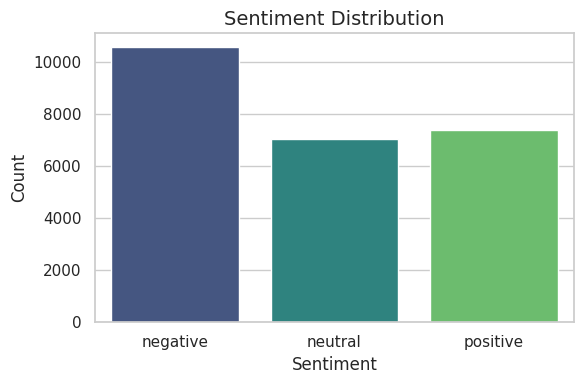

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
sns.set(style="whitegrid")

# Get unique sentiment labels sorted
sentiment_labels = sorted(df['sentiment'].unique())

# Optional: Map numerical to textual sentiment if needed
label_map = {
    0: 'Negative',
    1: 'Neutral',
    2: 'Positive'
}
label_names = [label_map.get(label, label) for label in sentiment_labels]

# Plot sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, order=sentiment_labels, palette='viridis')

# Set proper labels and ticks
plt.title('Sentiment Distribution', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=range(len(label_names)), labels=label_names)

# Show the plot
plt.tight_layout()
plt.show()


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target labels if not already in numeric format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])

# TF-IDF Vectorization with preprocessing options
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    lowercase=True,
    strip_accents='unicode'
)
X = vectorizer.fit_transform(df['clean_text'])

# Train-test split with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [66]:
# Model Training
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the model
model = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7489

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      2111
           1       0.65      0.62      0.63      1410
           2       0.77      0.73      0.75      1473

    accuracy                           0.75      4994
   macro avg       0.74      0.73      0.73      4994
weighted avg       0.75      0.75      0.75      4994



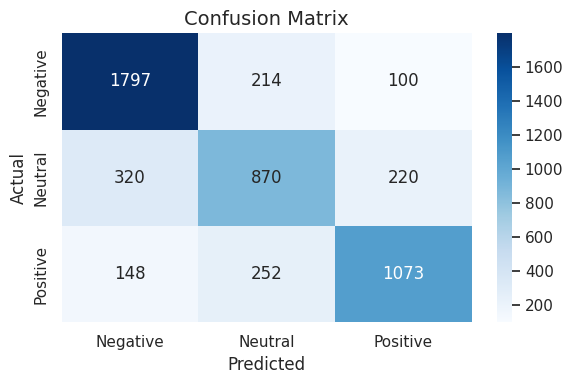

In [71]:
# Define sentiment labels
labels = ['Negative', 'Neutral', 'Positive']

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])  # Assuming 0=Neg, 1=Neu, 2=Pos

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

# Axis labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()


##  Real-Time Sentiment Prediction (User Input)

This section allows users to input their own tweets and receive an instant sentiment prediction. The model uses the trained Logistic Regression classifier and a pre-fitted TF-IDF vectorizer to analyze the sentiment of the provided tweet in real time.

Features:
- Cleans and vectorizes user input using the same pipeline as training data
- Predicts sentiment as **Positive 😊** or **Negative 😞**
- Runs in an interactive loop until the user types `exit`

 **Try it yourself below!**

 **\ ^ . ^ /**

In [72]:
def predict_sentiment(tweet):
    cleaned = clean_text(tweet)
    vec = vectorizer.transform([cleaned])
    pred = model.predict(vec)[0]

    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return label_map.get(pred, "Unknown")

# --- Interactive Loop ---
print("Sentiment Analyzer Ready. Type a tweet to analyze (or 'exit' to quit):\n")

while True:
    user_input = input("> ").strip()

    if user_input.lower() == 'exit':
        print("\nExiting the sentiment predictor. Goodbye.")
        break
    elif not user_input:
        print("Please enter a non-empty tweet.\n")
        continue

    sentiment = predict_sentiment(user_input)
    print(f"Sentiment Prediction: {sentiment}\n")


Sentiment Analyzer Ready. Type a tweet to analyze (or 'exit' to quit):

> Had a fantastic time at the concert last night. Everything was perfect.
Sentiment Prediction: Positive

> I'm currently at the airport waiting for my flight.
Sentiment Prediction: Neutral

> The meeting is scheduled for 3 PM tomorrow.
Sentiment Prediction: Neutral

> The delay was frustrating and completely avoidable.
Sentiment Prediction: Negative

> exit

Exiting the sentiment predictor. Goodbye.


## End